In [1]:
import theseus as th
from acceleration_control_planner import MotionPlannerObjective
import torch
import numpy as np
import matplotlib.pyplot as plt

dtype = torch.double
device = torch.device("cpu")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
CELL_SIZE = 0.05
HORIZON = 30
TOTAL_TIME = 60.0 # this dictates the discretization time step (dt = TOTAL_TIME / HORIZON)
CURRENT_STATE = torch.tensor((45*CELL_SIZE, 40*CELL_SIZE, 0))  # x, y, theta
GOAL_POSITION = torch.tensor((45*CELL_SIZE, 20*CELL_SIZE))  # x, y
SDF_ORIGIN = (0, 0)

In [3]:
objective = MotionPlannerObjective(
    total_time=TOTAL_TIME,
    horizon=HORIZON,
    current_velocity=torch.tensor([0.0, 0.0], dtype=dtype),
    x_velocity_bounds=torch.tensor([-5, 5], dtype=dtype),
    y_velocity_bounds=torch.tensor([-5, 5], dtype=dtype),
    x_acceleration_bounds=torch.tensor([-1, 1], dtype=dtype),
    y_acceleration_bounds=torch.tensor([-1, 1], dtype=dtype),
    robot_radius=1,  # REPLACE WITH ACTUAL RADIUS
    safety_distance=1,  # REPLACE WITH ACTUAL SAFETY DISTANCE
    local_map_size=60,  # REPLACE WITH ACTUAL MAP SIZE
    goal_cost = 50,
    quadratic_acceleration_cost = 10,
    velocity_bounds_cost = 2000,
    acceleration_bounds_cost = 2000,
    current_state_cost = 2000,
    dynamic_cost = 2000,
    collision_cost = 2000
)

optimizer = th.LevenbergMarquardt(
    objective,
    th.CholeskyDenseSolver,
    max_iterations=15,
    step_size=1,
)
motion_planner = th.TheseusLayer(optimizer)
motion_planner.to(device, dtype=torch.double)


In [4]:
def get_inputs(horizon):
    # Returns a dictionary with state and acceleration variable names associated to a
    # straight line trajectory between start and goal in SE(2) space

    # Calculate start and goal positions
    # start_pos = start[..., :2]  # Extracting the 2D position from SE(2)
    # goal_pos = goal  # Assuming goal is already a 2D point

    # # Calculate distances and average accelerations for each batch element
    # start_goal_dist = goal_pos - start_pos  # Shape: (batch_size, 2)
    # avg_acc = 2 * start_goal_dist / (total_time**2)  # Shape: (batch_size, 2)
    # unit_horizon = start_goal_dist / (horizon - 1)  # Shape: (batch_size, 2)

    # Create input dictionary
    input_dict = {}

    for i in range(horizon + 1):
        # state_i = start_pos + unit_horizon * i  # Shape: (batch_size, 2)
        # Concatenate the 2D position with the orientation
        input_dict[f"state_{i}"] = torch.tensor([0.0, 0.0, 1.0, 0.0], requires_grad=True, dtype=torch.double).view(1, 4)

        if i == horizon:
            continue

        # if i == 0 or i == horizon - 1:
        #     # Zero acceleration at start and end
        acceleration_i = torch.zeros(1, 2, requires_grad = True, dtype=torch.double)

        input_dict[f"acceleration_{i}"] = acceleration_i

    return input_dict


torch.Size([60, 60])


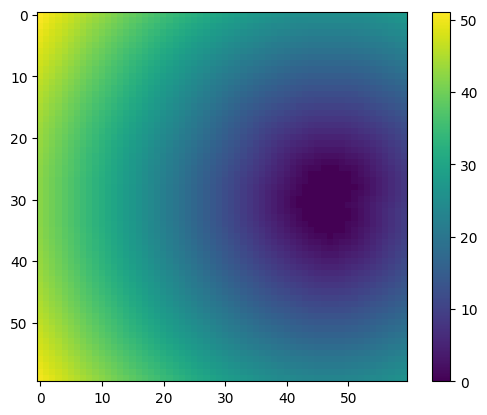

In [5]:

file_path = "sdf_array_2.npy"
sdf = torch.tensor(np.load(file_path), dtype=dtype)
plt.imshow(sdf)
plt.colorbar()
print(sdf.shape)

In [6]:
planner_inputs = {
    # REPLACE WITH SDF DATA
    'sdf_data': sdf.unsqueeze(0).to(device),
    'sdf_origin': torch.tensor([SDF_ORIGIN[0], SDF_ORIGIN[1]], dtype=dtype).unsqueeze(0).to(device),
    'cell_size': torch.tensor([CELL_SIZE], dtype=dtype).unsqueeze(0).to(device),
    'current_state': torch.tensor([CURRENT_STATE[0], CURRENT_STATE[1], torch.cos(CURRENT_STATE[2]), torch.sin(CURRENT_STATE[2])], dtype=dtype).unsqueeze(0).to(device),
    'goal_position': torch.tensor([GOAL_POSITION[0], GOAL_POSITION[1]], dtype=dtype).unsqueeze(0).to(device),
}
planner_inputs.update(get_inputs(HORIZON))


In [7]:
import time
start = time.perf_counter()
# with torch.no_grad():
final_values, info = motion_planner.forward(
    planner_inputs,
    optimizer_kwargs={
        "track_best_solution": True,
        "verbose": True,
        "damping": 0.1,
    }
)
end = time.perf_counter()
print(f"Time: {end - start}")

solution_dictionary = info.best_solution

Nonlinear optimizer. Iteration: 0. Error: 18352343.75
Nonlinear optimizer. Iteration: 1. Error: 33301049.986322865
Nonlinear optimizer. Iteration: 2. Error: 27858617.54438047
Nonlinear optimizer. Iteration: 3. Error: 18230501.49922268
Nonlinear optimizer. Iteration: 4. Error: 372970.43291632464
Nonlinear optimizer. Iteration: 5. Error: 31521.228822622885
Nonlinear optimizer. Iteration: 6. Error: 150572.03572595376
Nonlinear optimizer. Iteration: 7. Error: 5060.134458617299
Nonlinear optimizer. Iteration: 8. Error: 5060.133839074384
Nonlinear optimizer. Iteration: 9. Error: 5060.13383906834
Time: 0.4969512930001656


In [8]:
def dummy_loss(solution_dict):
    loss = 0.0
    for i in range(HORIZON + 1):
        state_key = f"state_{i}"
        state = solution_dict[state_key]
        loss += torch.sum(state)

    for i in range(HORIZON):
        acceleration_key = f"acceleration_{i}"
        acceleration = solution_dict[acceleration_key]
        loss += torch.sum(acceleration)

    return loss

In [9]:
loss = dummy_loss({k: t.tensor.clone() for (k, t) in motion_planner.objective.optim_vars.items()})
loss.backward()
print([planner_inputs[f'acceleration_{i}'].grad for i in range(HORIZON)])
# NOTE: only the initial acceleration tensors actually have gradients, since those are the only leaf tensors. 

[tensor([[-1.0076e-18,  2.2872e-18]], dtype=torch.float64), tensor([[-3.9249e-15,  8.8933e-15]], dtype=torch.float64), tensor([[-3.6509e-15,  8.2605e-15]], dtype=torch.float64), tensor([[-3.1893e-15,  7.2071e-15]], dtype=torch.float64), tensor([[-2.5104e-15,  5.6664e-15]], dtype=torch.float64), tensor([[-1.5768e-15,  3.5534e-15]], dtype=torch.float64), tensor([[-3.4432e-16,  7.6829e-16]], dtype=torch.float64), tensor([[ 5.6646e-16, -1.2895e-15]], dtype=torch.float64), tensor([[ 1.2044e-15, -2.7305e-15]], dtype=torch.float64), tensor([[ 1.6166e-15, -3.6615e-15]], dtype=torch.float64), tensor([[ 1.8473e-15, -4.1819e-15]], dtype=torch.float64), tensor([[ 1.9363e-15, -4.3820e-15]], dtype=torch.float64), tensor([[ 1.9186e-15, -4.3411e-15]], dtype=torch.float64), tensor([[ 1.8245e-15, -4.1276e-15]], dtype=torch.float64), tensor([[ 1.6793e-15, -3.7986e-15]], dtype=torch.float64), tensor([[ 1.5038e-15, -3.4011e-15]], dtype=torch.float64), tensor([[ 1.3144e-15, -2.9724e-15]], dtype=torch.float6

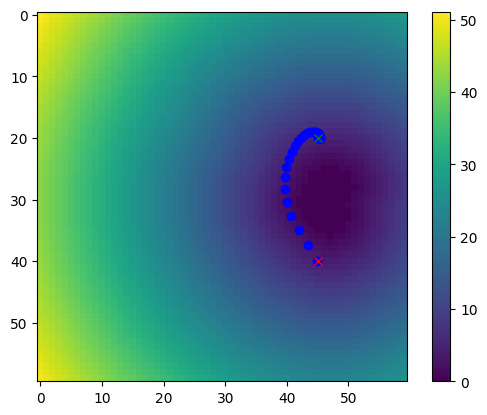

In [10]:
state_values = {
    key: value for key, value in solution_dictionary.items() if "state" in key
}
trajectory = torch.stack(list(state_values.values()), dim=0)

plt.imshow(sdf)
for x, y, a, b in trajectory.squeeze():
    plt.plot(x/CELL_SIZE, y/CELL_SIZE, 'bo')

plt.plot(CURRENT_STATE[0]/CELL_SIZE, CURRENT_STATE[1]/CELL_SIZE, 'rx')
plt.plot(GOAL_POSITION[0]/CELL_SIZE, GOAL_POSITION[1]/CELL_SIZE, 'gx')
plt.colorbar()
plt.show()
